# Libs and raw DataFrame

In [4]:
import pandas as pd
import math as mt
from math import radians, cos, sin, asin, sqrt
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter
from sklearn.feature_selection import f_regression 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.model_selection import GridSearchCV

***I already created and treated our base df, and chose to separate the creation of the df and the rest of the project to make things easier to understand. But all the steps to do so can be found in the notebook 'creating_and_treating_df'*** 

Here, we will just load the file 

In [5]:
#loading our df

shipping_df = pd.read_csv('generated_files\olist_shipping_base_df.csv')

shipping_df.head(3)

,shipping_price,price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_lat,customer_lng,seller_lat,seller_lng
0,13.29,58.9,650.0,28.0,9.0,14.0,-21.762775,-41.309633,-22.496953,-44.127492
1,17.96,55.9,650.0,28.0,9.0,14.0,-17.884337,-51.716990,-22.496953,-44.127492
2,18.33,64.9,650.0,28.0,9.0,14.0,-19.914323,-43.975703,-22.496953,-44.127492


# Feature Engineering

***We could start this project investigating the data, correlation between variables, how good our features are, etc. But considering our DataFrame and goal, it is very clear that we need to create at least two new features:***

+ The delivery distance based on the coordinates of customers and sellers
+ The volume of the package based on the measurements 

So we chose to first create the obvious features, and later check the rest of the data.

Please note that we intend to use an Tree-based model, so we wont need to apply any normalization 

***Lets start with the delivery distance***

In [6]:
def coordinates_distance(df):
    
    """ Return a transformed DataFrame with a new feature -- delivery_distance_km 
    delivery_distance_km will be the distance between two pairs of coordinates, in kilometers.
    We will use Haversine formula to calculate the distance. 

    Keyword arguments:
    df -- DataFrame with two pairs of coordinates ['seller_lng','seller_lat','customer_lng','customer_lat']
    """
    
    # Coordinates in radians 
    lng_seller = radians(df.seller_lng)
    lat_seller = radians(df.seller_lat)
    lng_customer = radians(df.customer_lng)
    lat_customer = radians(df.customer_lat)
    
    # Variables 
    dist_lat = lat_customer - lat_seller
    dist_lng = lng_customer - lng_seller
    r = 6371  #Radius of earth in kilometers.
    
    # Haversine formula
    h = sin(dist_lat/2)**2 + cos(lat_seller)*cos(lat_customer)*sin(dist_lng / 2)**2
    d = 2*r*asin(sqrt(h))
    
    df['delivery_distance_km'] = d
    
    return df

In [7]:
shipping_df2 = shipping_df.apply(coordinates_distance,axis =1)

shipping_df2.sample(3)

,shipping_price,price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_lat,customer_lng,seller_lat,seller_lng,delivery_distance_km
18889,7.60,49.00,250.0,16.0,2.0,11.0,-23.672295,-46.747868,-23.652366,-46.755753,2.357060
11658,92.95,230.00,12250.0,45.0,35.0,45.0,-13.066933,-55.932543,-23.595499,-46.559727,1531.491624
74433,9.27,20.49,675.0,28.0,15.0,15.0,-22.934710,-47.020690,-23.941954,-46.302565,133.833373


In [8]:
# For the volume, we just need to multiply the dimensions

shipping_df2['product_volume_cm3'] = (shipping_df2['product_length_cm']*
                                 shipping_df2['product_height_cm']*
                                 shipping_df2['product_width_cm'])

shipping_df2.sample(1)

,shipping_price,price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_lat,customer_lng,seller_lat,seller_lng,delivery_distance_km,product_volume_cm3
91884,19.91,59.9,8525.0,27.0,58.0,28.0,-29.913725,-51.12647,-23.571276,-46.479397,842.563751,43848.0


# Feature Selection 

***First of all, we can drop all the coordinates infos. They were used used to create the delivery distance, but its clear that beyond that, they will not bring useful information to the model***

In [9]:
shipping_df3 = shipping_df2.drop(['customer_lat','customer_lng','seller_lat','seller_lng'],axis = 1)

shipping_df3.head(1)

,shipping_price,price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_distance_km,product_volume_cm3
0,13.29,58.9,650.0,28.0,9.0,14.0,301.504681,3528.0


***For the next steps we will need to start checking correlations and understand which features we should keep, which we should transform and which we should drop.***

In [10]:
#lets take a quick look at all correlations 

shipping_df3.corr()

,shipping_price,price,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_distance_km,product_volume_cm3
shipping_price,1.000000,0.412854,0.610279,0.306303,0.389534,0.321977,0.392030,0.583328
price,0.412854,1.000000,0.338376,0.143939,0.222195,0.172972,0.086777,0.298765
product_weight_g,0.610279,0.338376,1.000000,0.460138,0.584121,0.507091,-0.006828,0.805322
product_length_cm,0.306303,0.143939,0.460138,1.000000,0.191636,0.532845,-0.003078,0.540822
product_height_cm,0.389534,0.222195,0.584121,0.191636,1.000000,0.279977,0.000629,0.723857
product_width_cm,0.321977,0.172972,0.507091,0.532845,0.279977,1.000000,-0.018467,0.625037
delivery_distance_km,0.392030,0.086777,-0.006828,-0.003078,0.000629,-0.018467,1.000000,-0.010036
product_volume_cm3,0.583328,0.298765,0.805322,0.540822,0.723857,0.625037,-0.010036,1.000000


Neither of our features shows a high correlation with the shipping price, in other hand they all shows a relationship with it. This means that separately, the features will have little influence on the shipping price, but together they can fit a good model.

**f_regression:** 

To further check the significance of features we will use f_regression.

f_regression will return F-statistic and p-values associated with the F-statistic. 

+ F-statistic: significance of each feature in improving the model.
+ p-values: if <0.005 feature is relevant

In [11]:
#f_regression

x = shipping_df3[shipping_df3.columns[1:].tolist()]
y = shipping_df3['shipping_price']

f_stats_values = f_regression(x,y)[0]
p_values = f_regression(x,y)[1] #para obter somente os p_values

f_regression_df = pd.DataFrame({'Feature':shipping_df3.columns[1:].tolist(),
                                'f_statistic' : f_stats_values,
                                'p_values':p_values
                               })

f_regression_df

,Feature,f_statistic,p_values
0,price,22638.166537,0.0
1,product_weight_g,65387.056125,0.0
2,product_length_cm,11407.228420,0.0
3,product_height_cm,19708.367512,0.0
4,product_width_cm,12742.992808,0.0
5,delivery_distance_km,20007.758599,0.0
6,product_volume_cm3,56826.630421,0.0


All the P=values = 0. This means that all features are relevant. But we can also see that the measurements features used to create volume (length, height and width) are the less relevant. 

Also, this three features are obviously related with volume, which means they can be redundant.

**Detecting Multicollinearity with VIF**

to check feature redundancy we will use a technique to detect multicollinearity, the VIF.

+ A VIF of 1 (the minimum possible VIF) means the tested predictor is not correlated with the other predictors.
+ Generally, a VIF above 5 indicates a high multicollinearity. 

In [12]:
X_variables = shipping_df3.drop(['shipping_price'],axis = 1)

In [13]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,price,1.611811
1,product_weight_g,3.854915
2,product_length_cm,5.647449
3,product_height_cm,3.947467
4,product_width_cm,6.387224
5,delivery_distance_km,1.905637
6,product_volume_cm3,5.867692


As expected, the measurements showed high collinearity, especially  product_length_cm, product_width_cm and product_volume_cm3

But unlike what we expected, product_height_cm did not show a multicollinearity as high as the other measurements, showing that, perhaps, height has a different influence on the shipping price.

**Choosing features**

First, with the correlation and f_regression analysis, we can focus our decision in three features:  product_length_cm, product_height_cm and product_width_cm. The others, showed a hight relevance in the f_statistic test.

Now, looking at the Multicollinearity analysis, we see a hight multicollinearity between length, height, width, volume and weight. As mentioned above, weight and volume have a hight relevance, so it don't make sense to drop then. We could drop all three features (length, height, width) but the height feature showed a not so hight multicollinearity and have the biggest relevance between those three, **so we chose to keep product_height_cm for now and drop product_length_cm and product_width_cm.**]



In [14]:
shipping_df4 = shipping_df3.drop(['product_length_cm','product_width_cm'],axis =1)
shipping_df4.head(2)

,shipping_price,price,product_weight_g,product_height_cm,delivery_distance_km,product_volume_cm3
0,13.29,58.9,650.0,9.0,301.504681,3528.0
1,17.96,55.9,650.0,9.0,943.308218,3528.0


# Dealing with Outliers

***To start our outlier analysis, let's create two histograms to understand the shipping price variation. The first with all values and the second only with high fees (>100)***

count    110179.000000
mean         19.949359
std          15.699213
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: shipping_price, dtype: float64

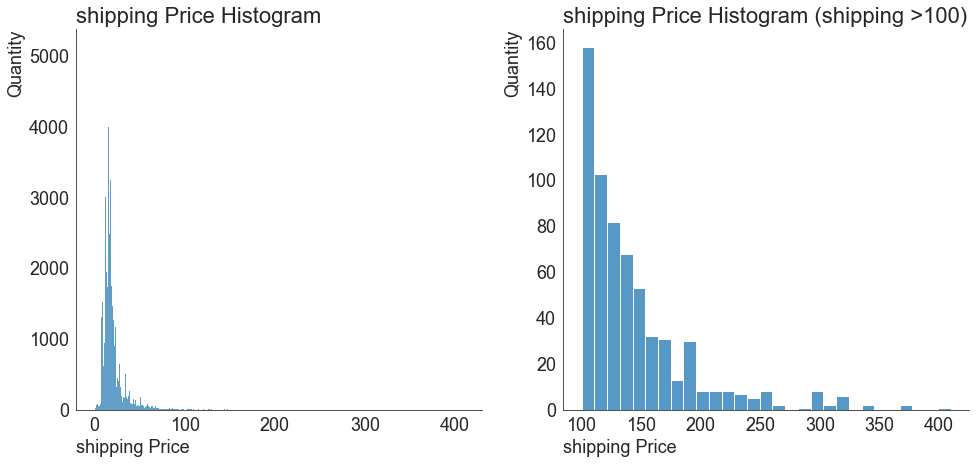

There is :
638 shipping prices higher then 100$
66 shipping prices higher then 200$


In [15]:

display(shipping_df4.shipping_price.describe())

sns.set_style('white')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,7))

sns.histplot(data =shipping_df4.shipping_price,ax = ax1)
ax1.set_title("shipping Price Histogram",fontsize = 22, loc = 'left')
ax1.set_xlabel("shipping Price",fontsize=18,loc = 'left')
ax1.set_ylabel("Quantity",fontsize=18,loc ='top')
ax1.tick_params(labelsize=18)

high_shipping = shipping_df4[shipping_df4.shipping_price>100]
sns.histplot(data =high_shipping.shipping_price,ax = ax2)
ax2.set_title("shipping Price Histogram (shipping >100)",fontsize = 22, loc = 'left')
ax2.set_xlabel("shipping Price",fontsize=18,loc = 'left')
ax2.set_ylabel("Quantity",fontsize=18,loc ='top')
ax2.tick_params(labelsize=18)
sns.despine()
plt.show()
print(f'There is :\n{len(high_shipping)} shipping prices higher then 100$'
      f'\n{len(high_shipping[high_shipping.shipping_price>200])} shipping prices higher then 200$')

***We have some very high shipping  (proportionally).*** 

If those values are associated with big weights and\or long delivery distances, it may not be an issue. Otherwise, we are dealing with outliers and we should drop those values before training our model.


In [16]:
#first, let's look at those high shipping to see if they make sense

shipping_df4[shipping_df4.shipping_price>200].sort_values(by =['shipping_price'],ascending = False).head(10)

,shipping_price,price,product_weight_g,product_height_cm,delivery_distance_km,product_volume_cm3
103259,409.68,979.00,14675.0,64.0,1864.717005,183040.0
95573,375.28,2338.08,30000.0,58.0,456.909891,282750.0
95574,375.28,2338.08,30000.0,58.0,449.543170,282750.0
103268,339.59,1149.00,25250.0,66.0,617.547173,296208.0
60566,338.30,1050.00,30000.0,75.0,1708.130756,251625.0
60568,322.10,1050.00,30000.0,75.0,433.066669,251625.0
60549,321.88,1050.00,30000.0,75.0,632.245580,251625.0
96347,321.46,990.00,30000.0,50.0,241.638155,250000.0
84433,317.47,3089.00,11300.0,34.0,2819.654440,37400.0
96348,314.40,1045.00,30000.0,50.0,1689.121740,250000.0


Looks like those expenses shippings are associated with heavy products. But does every heavy product has a expensive shipping? And concerning to the features is there any outlier that needs further investigation?

To answer these questions let's plot a scatterplot matrix to quickly analyze all our features

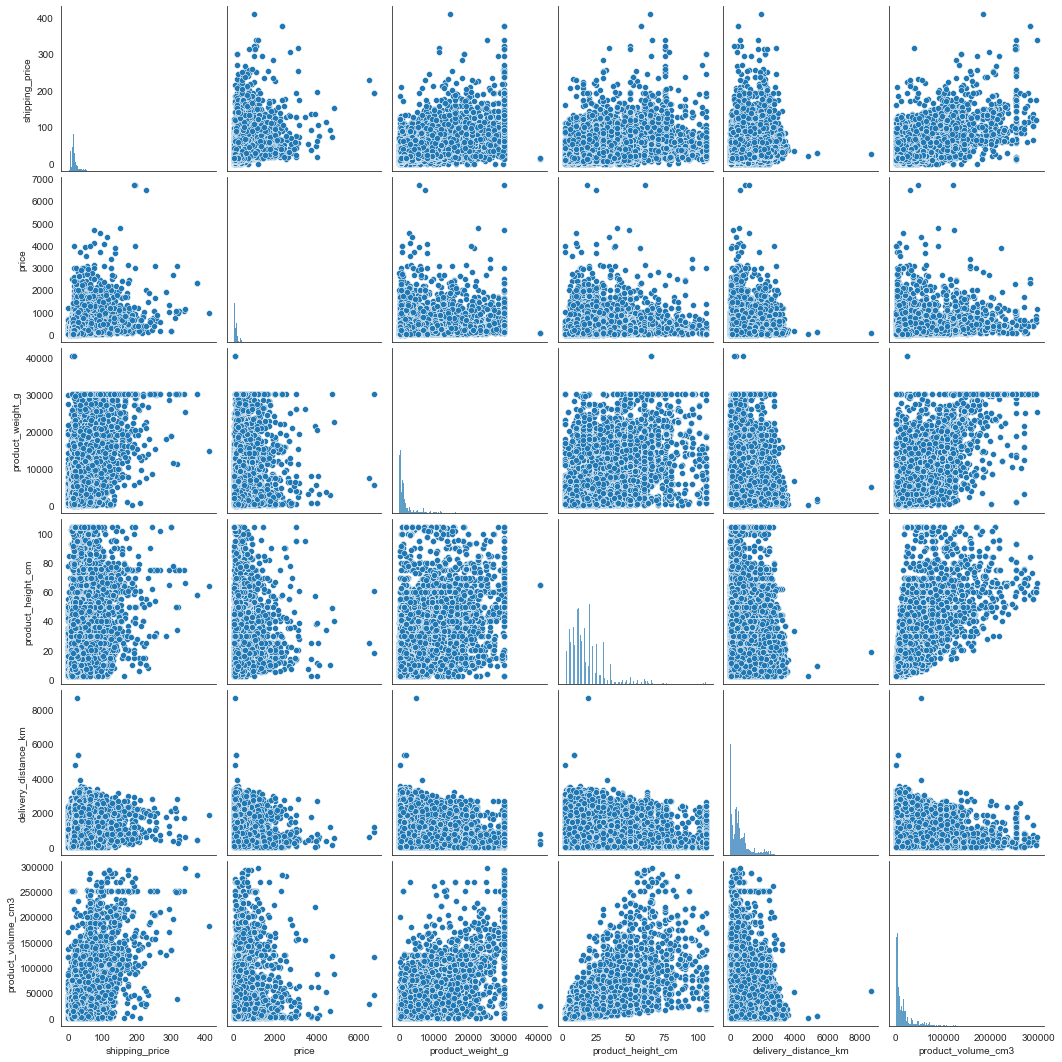

In [17]:
sns.pairplot(shipping_df4)
plt.show()

First of all, we see that not necessarily heavy products has higher shippings, therefore those hight prices are the result of a number of factors.

We can also note possible outiliers in the features price, product_weight_g and delivery_distance_km. Let's take a closer look in those.

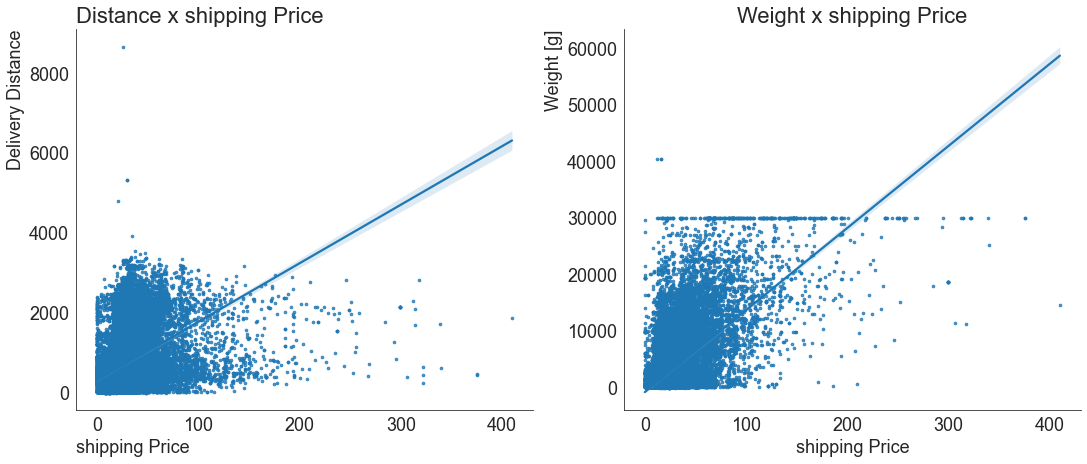

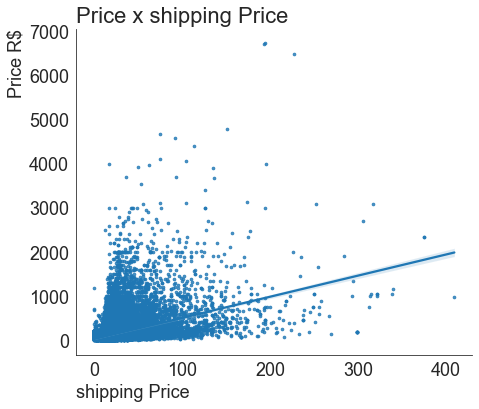

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,7))

sns.regplot(x=shipping_df4['shipping_price'], y=shipping_df4['delivery_distance_km'], scatter_kws={'s':7},ax=ax1)
ax1.set_title("Distance x shipping Price",fontsize = 22, loc = 'left')
ax1.set_xlabel("shipping Price",fontsize=18,loc= 'left')
ax1.set_ylabel("Delivery Distance",fontsize=18,loc = 'top')
ax1.tick_params(labelsize=18)


sns.regplot(x=shipping_df4['shipping_price'], y=shipping_df4['product_weight_g'],scatter_kws={'s':7},ax=ax2)
ax2.set_title("Weight x shipping Price",fontsize = 22)
ax2.set_xlabel("shipping Price",fontsize=18)
ax2.set_ylabel("Weight [g]",fontsize=18,loc = 'top')
ax2.tick_params(labelsize=18)
sns.despine()
plt.show()

fig2, (ax3) = plt.subplots(figsize=(7.1,6))
sns.regplot(x=shipping_df4['shipping_price'], y=shipping_df4['price'],scatter_kws={'s':7},ax=ax3)
ax3.set_title("Price x shipping Price",fontsize = 22,loc= 'left')
ax3.set_xlabel("shipping Price",fontsize=18,loc= 'left')
ax3.set_ylabel("Price R$",fontsize=18,loc = 'top')
ax3.tick_params(labelsize=18)
sns.despine()
plt.show()

***Those views were very insightful. First of all, we notice that definitely the biggest shipping, in many cases, may not be explained by heavy weights neither long distances. we were also able to identify outliers in  distance, weight and price features. Those outliers can not be explained and will probably have a negative effect on our model. So we will drop outliers by these rules:***

+ drop lines with shipping > 250 and weight < 28000
+ drop lines with shipping > 150 and weight < 7500
+ drop lines with weight > 35000
+ drop lines with distance > 4000
+ drop lines with price > 6000


In [19]:
#Before droping, lets check if we are not droping to much info

print(f'Rule 1 len: {len(shipping_df2[(shipping_df2.shipping_price>250) & (shipping_df2.product_weight_g<25000)])}'
      f'\nRule 2 len: {len(shipping_df2[(shipping_df2.shipping_price>150) & (shipping_df2.product_weight_g<7500)])}'
      f'\nRule 3 len: {len(shipping_df2[shipping_df2.product_weight_g>35000])}'
      f'\nRule 4 len: {len(shipping_df2[shipping_df2.delivery_distance_km>4000])}'
      f'\nRule 5 len: {len(shipping_df2[shipping_df2.price>6000])}')

Rule 1 len: 11
Rule 2 len: 7
Rule 3 len: 3
Rule 4 len: 4
Rule 5 len: 3


Only a few data will be dropped, looks like we are good to continue

In [20]:
shipping_df5 = shipping_df4.copy()

shipping_df5 = shipping_df5[~((shipping_df5.shipping_price>250) & (shipping_df5.product_weight_g<25000))]
shipping_df5 = shipping_df5[~((shipping_df5.shipping_price>150) & (shipping_df5.product_weight_g<7500))]
shipping_df5 = shipping_df5[shipping_df5.product_weight_g<35000]
shipping_df5 = shipping_df5[shipping_df5.delivery_distance_km<4000]
shipping_df5 = shipping_df5[shipping_df5.price<6000]


shipping_df5.reset_index(drop = True, inplace = True)
print(shipping_df5.shape)
shipping_df5.head(3)

(110153, 6)


,shipping_price,price,product_weight_g,product_height_cm,delivery_distance_km,product_volume_cm3
0,13.29,58.9,650.0,9.0,301.504681,3528.0
1,17.96,55.9,650.0,9.0,943.308218,3528.0
2,18.33,64.9,650.0,9.0,287.605969,3528.0


# Building the Model

## Metrics and Baselines

First of all, lets create a Baseline and define our metrics to compare our results. 

**Baseline:**

First, let's use the simplest baseline possible: the overall average. And to make our analysis more robust, let's also use one based on the feature that showed the greatest correlation, the weight. We can divide our orders in weights clusters and take a mean shipping value for each cluster. 

+ Total mean 
+ Mean by weights clusters

**Metrics:**

For the metrics, we will use the classic ones for regression models: 

+ MAE: The absolute error is very meaningful to us, considering that we are dealing with a price value
+ RMSE: Very helpful to identify outliers, i.e, big errors  

In [21]:
def weight_cluster(df):
    
    """Return the weight cluster (new feature) based on weights percentils 

    Keyword arguments:
    df -- The shipping DataFrame, containing the weight feature.
    """    
    
    # shipping_df5 is the DataFrame that will feed the model
    top_25 = np.percentile(shipping_df5.product_weight_g, 25 )
    top_50 = np.percentile(shipping_df5.product_weight_g, 50 )
    top_75 = np.percentile(shipping_df5.product_weight_g, 75 )
    
    if df.product_weight_g <= top_25:
        cluster = 1
    elif df.product_weight_g > top_25 and  df.product_weight_g <= top_50:
        cluster = 2
    elif df.product_weight_g > top_50 and  df.product_weight_g <= top_75:
        cluster = 3
    elif df.product_weight_g > top_75:
        cluster = 4 
    return cluster


In [22]:
# Create the feature for weight cluster
shipping_by_weight = shipping_df5.copy()
shipping_by_weight['weight_cluster'] = shipping_df5.apply(weight_cluster,axis = 1)

# Build a summary with the mean shipping_price, group by cluster
shipping_by_cluster_w = shipping_by_weight.groupby('weight_cluster',as_index= False).shipping_price.mean()
shipping_by_cluster_w

,weight_cluster,shipping_price
0,1,14.769637
1,2,16.418993
2,3,18.099590
3,4,30.864508


In [23]:
def baseline(df = shipping_df5):
    
    """Return a DataFrame with the two chosen baselines and the respective metrics

    Keyword arguments:
    df -- the DataFrame that will feed the model (default shipping_df5)
    """
    
    df2 = df.copy()
    t_start = perf_counter()
    # Feature with total mean 
    df2['mean'] = np.mean(df2.shipping_price)
    
    # Feature with Mean by weights clusters
    df2['mean_by_weight'] = shipping_by_weight.weight_cluster.apply(
        lambda x:shipping_by_cluster_w[shipping_by_cluster_w.weight_cluster == x].shipping_price.values[0])
    
    # MAE 
    mae_mean_by_weight = mean_absolute_error(df2['shipping_price'], df2['mean_by_weight'])
    mae_mean = mean_absolute_error(df2['shipping_price'], df2['mean'])

    # RMSE
    rmse_mean_by_weight = mean_squared_error(df2['shipping_price'], df2['mean_by_weight'], squared=False)
    rmse_mean = mean_squared_error(df2['shipping_price'], df2['mean'], squared=False) 
    
    t_end = perf_counter()
    time = round(t_end-t_start,2) 
    result = pd.DataFrame({'MAE':[mae_mean,mae_mean_by_weight],
                           'RMSE':[rmse_mean,rmse_mean_by_weight],
                           'time':time},index = ['mean','mean by weight cluster'])
    return result

In [24]:
baseline_df = baseline()
baseline_df

,MAE,RMSE,time
mean,8.545924,15.361941,27.97
mean by weight cluster,7.599644,13.978497,27.97


##   Hyperparameter Tuning and Model Selection

***To make the selection, we are going to we will optimize the Hyperparameter (with grid search) of a few models and compare results.***

First, we will start with a simple ***linear Regression***, because sometimes simple is better. In this case, we will use the feature with the best correlation with the target to make our predictions: 'product_weight_g'.  (please note a Linear Regression model dont have Hyperparameters. So we can directly evaluate it.)

Since the other features don't have a high linear correlation with the target (however, have a relationship with it), it seems like a good idea to test models based on decision trees.

In this regard, **RandomForest** is a good option, still simple but able to consider all variables that can influence our target.

We are also going to test ***XGBoost***, a gradient boosted tree algorithm that is a little bit more complex, but also more efficient. It usually gives good results in regression problems

We already chose the metrics that will be used to evaluate the models (MAE, RMSE) but we haven't talk about the methods to get them, i.e, how to test the models. We will use two methods: 
+ For the tree-based models, we will use a cross-validation method, it will provide more stable and generalized results and help us to prevent overfitting
+ The Linear Regression model hardly will be overfitted, and considering that we have a good sample size, a train test split should be enough to evaluate it.

### Random Forest Hyperparameter Tuning


In [22]:
def random_forest_grid_search(X,y):
    
    """Return the best hyperparameters of pre-defined search space for a Random Forest Model 
    * We will focus on MAE optimization

    Keyword arguments:
    X -- Independent features - excluding target variable 
    y -- Dependent variable - target
    """
    
    t1_start = perf_counter()
    random_forest_search_space = {'n_estimators':[25,50,75,100],
                                  'max_depth':[None,6,10,15,20], 
                                  'min_samples_leaf':[1,6,8,10],
                                  'min_samples_split':[2,4,6]}

    rfr = RandomForestRegressor(random_state=42)
    gs = GridSearchCV(rfr, param_grid=random_forest_search_space, 
                      scoring="neg_mean_absolute_error", # The metric we need to focus on to reduce false negatives is Recall.
                      n_jobs=-2, cv=5, return_train_score=True)

    gs.fit(X, y)

    t1_stop = perf_counter()
    print(f'Grid search time: {round((t1_stop-t1_start)/60,2)}min')
    
    return gs.best_params_

In [23]:
# Finding best Random Forest hyperparameters
final_shipping_df = shipping_df5.copy()

X = final_shipping_df[final_shipping_df.columns[1:].tolist()]
y = final_shipping_df['shipping_price']

best_params_random_forest = random_forest_grid_search(X,y)
best_params_random_forest

Grid search time: 55.07min


{'max_depth': 10,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 100}

### XGBoost Hyperparameter Tuning

In [24]:
def xgboost_grid_search(X,y):
        
    """Return the best hyperparameters of pre-defined search space for a XGBoost Model 
    * We will focus on MAE optimization

    Keyword arguments:
    X -- Independent features - excluding target variable 
    y -- Dependent variable - target
    """
    
    t1_start = perf_counter()
    
    xgboost_search_space = {'n_estimators':[25,50,75,100],
                            'max_depth':[None,6,10,15,20,25],
                            'learning_rate':[0.02,0.04,0.05,0.06,0.07,0.1]}

    xgb = XGBRegressor(random_state=42, eval_metric='mlogloss')
    gs = GridSearchCV(xgb, param_grid=xgboost_search_space, 
                      scoring="neg_mean_absolute_error", # The metric we need to focus on to reduce false negatives is Recall.
                      n_jobs=-3, cv=5, return_train_score=True)

    gs.fit(X, y)

    t1_stop = perf_counter()
    print(f'Grid search time: {round((t1_stop-t1_start)/60,2)}min')
    
    return gs.best_params_

In [25]:
# Finding best XGBoost hyperparameters
final_shipping_df = shipping_df5.copy()

X = final_shipping_df[final_shipping_df.columns[1:].tolist()]
y = final_shipping_df['shipping_price']

best_params_xgboost = xgboost_grid_search(X,y)
best_params_xgboost

Grid search time: 98.55min


{'learning_rate': 0.06, 'max_depth': None, 'n_estimators': 50}

### Model Selection

***let's use the hyperparameters found with grid search to evaluate all models with cross-validation***

In [25]:
def avaliate_models(X,y,baseline):
       
    """Builds models with optimized hyperparameters and evaluate them with cross validation. 
    Return a DataFrame with results (metrics), and time to evaluate.

    Keyword arguments:
    baseline -- baseline DataFrame, will be added to the results for comparison
    X -- Train Data 
    y -- Validation Data 
    """
    
    final_results = pd.DataFrame() # to concatenate
    n_estimators,mae_scores,rmse_scores,models,time =[[] for i in range(5)]
    model_list = ['Linear Regression','RandomForest','XGBoost']
    for model in model_list:
        
        if model == 'Linear Regression':
            t_start = perf_counter()
    
            # sklearn only works with arrays
            X_linear = np.array(X['product_weight_g']).reshape((-1, 1))
            y_linear = np.array(y)

            # Split data into training and validation
            train_X, val_X, train_y, val_y = train_test_split(X_linear, y_linear, random_state = 42)

            # Define model and predict values
            reg = LinearRegression().fit(train_X,train_y)
            predictions = reg.predict(val_X)

            # Calculate metrics
            mae_linear_regression = mean_absolute_error(val_y, predictions)
            rmse_linear_regression = mean_squared_error(val_y, predictions, squared=False) 

            # Apeend results
            t_end = perf_counter()
            time.append(round(t_end-t_start,2))
            mae_scores.append(mae_linear_regression)
            rmse_scores.append(rmse_linear_regression)
            models.append(model)

        if model == 'RandomForest':
            t_start = perf_counter()

            rfr = RandomForestRegressor(max_depth = 10,min_samples_leaf = 8,
                                        min_samples_split = 2, n_estimators=100, random_state=42)
            scores = cross_validate(rfr,
                                    X, y,
                                    cv=5,
                                    scoring=('neg_mean_absolute_error','neg_root_mean_squared_error'))

            t_end = perf_counter()
            time.append(round(t_end-t_start,2))
            # Multiply by -1 since sklearn calculates *negative* MAE and RMSE
            mae_scores.append(-1*scores.get('test_neg_mean_absolute_error').mean())
            rmse_scores.append(-1*scores.get('test_neg_root_mean_squared_error').mean())
            models.append(model)
                
        if model == 'XGBoost':
          
            t_start = perf_counter()
            xg_model = XGBRegressor(n_estimators=50, learning_rate= 0.06,max_depth = None, random_state =42 )
            scores = cross_validate(xg_model,
                                    X, y,
                                    cv=5,
                                    scoring=('neg_mean_absolute_error','neg_root_mean_squared_error'))

            t_end = perf_counter()
            time.append(round(t_end-t_start,2))
            # Multiply by -1 since sklearn calculates *negative* MAE and RMSE
            mae_scores.append(-1*scores.get('test_neg_mean_absolute_error').mean())
            rmse_scores.append(-1*scores.get('test_neg_root_mean_squared_error').mean())
            models.append(model)
    
    
    result = pd.DataFrame({'MAE':mae_scores,
                           'RMSE':rmse_scores,
                           'time':time},index = models)
        
    # Adding Baseline
    final_result2 = pd.concat([baseline,result]) 
    final_result2.index.name = 'Model'
    return final_result2

In [26]:
#lets avaliate 
final_shipping_df = shipping_df5.copy()

X = final_shipping_df[final_shipping_df.columns[1:].tolist()]
y = final_shipping_df['shipping_price']

model_evaluation =  avaliate_models(X,y,baseline_df)
model_evaluation

,MAE,RMSE,time
Model,,,
mean,8.545924,15.361941,27.97
mean by weight cluster,7.599644,13.978497,27.97
Linear Regression,6.875315,12.175944,0.48
RandomForest,4.490664,9.024787,76.15
XGBoost,4.347619,9.000255,13.23


***We can see very good improvements from our baselines!***

Its clear that the best model is the XGBoost. 

This Model shows:

+ MAE = 4.35
+ RMSE = 9.00

Considering our Baselines metrics: MAE(8.54, 7.60) and RMSE (15.3, 13.98) we can say that our model was able to practically cut the error in half! 

Also, as expected, the regression model had the worst results (although there was still an improvement compared to the baselines), after all, the predict variable used 'product_weight_g' had a  Pearson Correlation coefficient of only 0.61, that is, the linear correlation was not very high.

# Evaluating the learning curve (Overfitting/Underfitting Analysis)

Our Model showed good results. Even so, we can always improve. let's evaluate the learning curve to understand if the model suffered overfit or underfit, and what would be the best way if we want to improve our model even more.

We will first evaluate the learning curve varying the data size used for model training. This is a good way to identify the best path to improve the model, e.g, adding more data, adding/improving features or improving hyperparameters.

In [27]:
def learning_curve(X,y):
    
    """Calculate all our metrics for training and validation data for different samples size.
    * Return a DataFrame with results
    * DataFrame will be used to build the learning curve

    Keyword arguments:
    X -- Independent features - excluding target variable 
    y -- Dependent variable - target
    """
    
    size_list, mae_val_list, rmse_val_list, mae_train_list, rmse_train_list =[[] for i in range (5)]
    for test_size in range(2,82,2): # increase samples qnt. in 5%  each loop
        
        test_size_f =  1 - test_size/100
        # train test split 
        X_train, X_val, y_train, y_val = train_test_split(X, np.array(y),test_size= test_size_f, random_state=42) 
        
        
        
        # XGBoost regressor
        xg_model = XGBRegressor(n_estimators=50, learning_rate= 0.06,max_depth = None, random_state =42 )
        xg_model.fit(X_train,y_train)
        
        # Validation Metrics
        val_predict = xg_model.predict(X_val)
        mae_val = mean_absolute_error(y_val, val_predict)
        rmse_val = mean_squared_error(y_val, val_predict, squared=False)
                
        # Training Metrics
        train_predict = xg_model.predict(X_train)
        mae_train = mean_absolute_error(y_train, train_predict)
        rmse_train = mean_squared_error(y_train, train_predict, squared=False)

        # appending results
        size_list.append(len(X_train))
        mae_val_list.append(mae_val)
        rmse_val_list.append(rmse_val)
        mae_train_list.append(mae_train)
        rmse_train_list.append(rmse_train)
        
    results_df = pd.DataFrame({'Train Size':size_list,
                               'MAE Val':mae_val_list,
                               'RMSE Val':rmse_val_list,
                               'MAE Train':mae_train_list,
                               'RMSE Train':rmse_train_list})
        
    return results_df

In [28]:
learning_curve_df = learning_curve(X,y)

In [29]:
learning_curve_df.head(2)

,Train Size,MAE Val,RMSE Val,MAE Train,RMSE Train
0,2203,4.577843,9.721289,3.206731,5.485031
1,4406,4.387962,9.415473,3.396510,6.035686


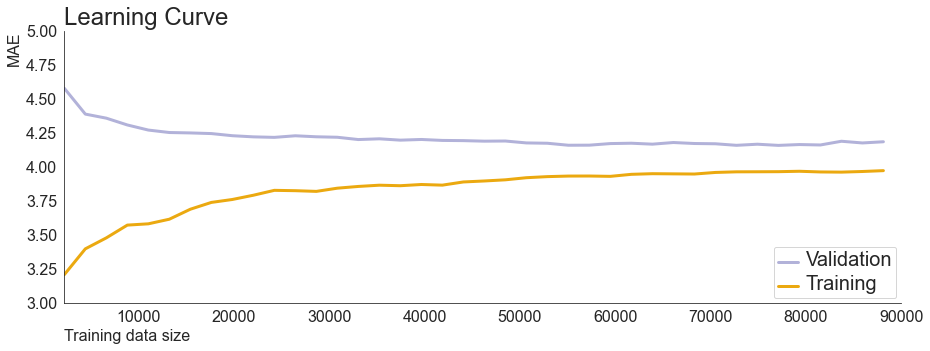

In [30]:
# Vizualizing learning curve

sns.set_style('white')
fig,ax1 = plt.subplots(figsize=(15,5))

sns.lineplot(x=learning_curve_df['Train Size'],
            y=learning_curve_df['MAE Val'],
            color ='#b2b2d9', label = 'Validation',
            lw =3, ax = ax1)

sns.lineplot(x=learning_curve_df['Train Size'],
            y=learning_curve_df['MAE Train'],
            color ='#eba910', label = 'Training',
            lw =3, ax = ax1)

ax1.set_title("Learning Curve",fontsize = 24, loc = 'left')
ax1.set_xlabel("Training data size",fontsize=16, loc = 'left')
ax1.set_ylabel("MAE",fontsize=16, loc ='top')
ax1.tick_params(labelsize=16)
plt.legend(loc = 'lower right')
plt.setp(ax1.get_legend().get_texts(), fontsize='20')
sns.despine()
plt.xlim(2203,90000)
plt.ylim(3,5)
plt.show() 

The learning curve brings us some interesting insights:

+ We observe that the gap between validation and testing data is small and constant, this means that ***our model does not have high variance (Overfitting)***. And we will not be able to improve the model by adding more data (unless the data in question contributes to the identification of some specific pattern, e.g. outliers) 
+ We also noticed that the MAE obtained is sufficient for the needs of the project, therefore, we can say that ***our model does not have a High Bias (Underfitting).***
+ However, if we want to further improve the performance of the model, through this analysis it is clear that the way forward would be ***to add more features to allow the model to learn more complex relationships*** and hopefully reduce the bias; or to ***test different machine learning algorithm/combine multiple models.***

In [31]:
# Looks like we have a good model! 
# Lets Fit and dump it to disk

# Split data into training and validation
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 42)

model = XGBRegressor(n_estimators=50, learning_rate= 0.06)
model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.06, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [32]:
# Calculating metrics of final model

predictions = model.predict(val_X)

mae = mean_absolute_error(val_y, predictions)
rmse = mean_squared_error(val_y, predictions, squared=False) 
bias = np.mean([i-j for i,j in zip(val_y,predictions)])

final_results_df = pd.DataFrame({'Final Metrics':[mae,rmse,bias]},index = ['MAE','RMSE','Bias'])
final_results_df

,Final Metrics
MAE,4.173901
RMSE,8.687211
Bias,1.049567


In [33]:
# save the model to disk

filename = r'generated_files\shipping_estimate_model.pkl'
pickle.dump(model, open(filename, 'wb'))